In [8]:
import pytorch_lightning as pl
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import numpy as np

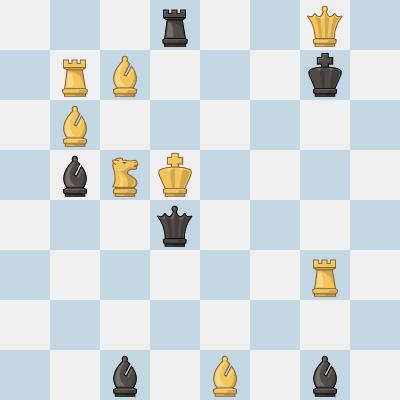

In [9]:
img_path = os.path.join('..', '..', 'data', 'raw', 'train', '3r2Q1-1RB3k1-1B6-1bNK4-3q4-6R1-8-2b1B1b1.jpeg')
img = Image.open(img_path)
img

In [10]:
img_trans = transforms.ToTensor()

In [11]:
X = img_trans(img)
X.shape

torch.Size([3, 400, 400])

In [12]:
class ChessCNN():
    def __init__(self):
        self.cnn_1 = nn.Conv2d(3, 5, (5, 5), 5) # Output: 5x80x80 (cells: 5x10x10)
        self.cnn_2 = nn.Conv2d(5, 8, (2, 2), 2) # Output: 8x40x40 (cells: 8x5x5)
        self.pool_1 = nn.MaxPool2d((5, 5), 5) # Output: 8x8x8 (cells: 8x1x1)
        self.cnn_3 = nn.Conv2d(8, 13, (1, 1)) # Output: 12x8x8 (cells: 13x1x1)

    def forward(self, X):
        X = self.cnn_1(X)
        X = self.cnn_2(X)
        X = self.pool_1(X)
        X = self.cnn_3(X)
        return X


mod = ChessCNN()
print(X.shape)
scores = mod.forward(X.unsqueeze(0))
scores.shape

torch.Size([3, 400, 400])


torch.Size([1, 13, 8, 8])

In [13]:
criterion = nn.CrossEntropyLoss()

actual = y.unsqueeze(0)
# .shape,  actual.shape
# scores.shape, actual.shape
# # pred = scores.argmax(axis=0)
criterion(scores, actual)
# actual.shape, scores.shape

NameError: name 'y' is not defined

In [ ]:
scores.shape
scores.argmax(dim=1).shape

torch.Size([1, 8, 8])

In [ ]:
a = './mnt'
a/'test'

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
from torchvision.datasets import DatasetFolder
from os import path
tr_path = path.join('..', '..', 'data', 'raw', 'train')

dataset = DatasetFolder(tr_path)

TypeError: DatasetFolder.__init__() missing 1 required positional argument: 'loader'

In [14]:
from os import path
from pathlib import Path
import pytorch_lightning as pl
from torchvision import transforms
from torch.utils.data.datapipes.utils.decoder import imagehandler
from torchdata import datapipes

def convert(data):
    path, img = data
    return Path(path).stem, img_trans(img)

train_pipe = datapipes.iter.FileLister(tr_path)
train_pipe = datapipes.iter.FileOpener(train_pipe, 'b')
train_pipe = datapipes.iter.RoutedDecoder(train_pipe, imagehandler('pil'))
train_pipe = datapipes.iter.Mapper(train_pipe, lambda data: convert)
next(iter(train_pipe))

NameError: name 'tr_path' is not defined

In [104]:
img_trans

ToTensor()

In [16]:
from os import path, listdir
from pathlib import Path
import pytorch_lightning as pl
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.datapipes.utils.decoder import imagehandler
from torchdata import datapipes
import numpy as np

BLACK_PIECES = ['p', 'b', 'k', 'r', 'n', 'q']
WHITE_PIECES = [x.upper() for x in BLACK_PIECES]
PIECE_ENCODING = {
    piece: i for (i, piece) in enumerate([np.nan] + BLACK_PIECES + WHITE_PIECES)
}

class ChessDataModule(pl.LightningDataModule):
    def __init__(self, path, batch_size = 64):
        super().__init__()
        self.path = path
        self.img_transforms = transforms.Compose([
            transforms.ToTensor()
        ])
        self.batch_size = batch_size


    def setup(self) -> None:
        train_path = path.join(self.path, 'train')
        train_size = len(listdir(train_path))
        
        pipe = datapipes.iter.FileLister(train_path)
        pipe = datapipes.iter.Enumerator(pipe)
        pipe = datapipes.map.IterToMapConverter(pipe)

        val_size = len(pipe) // 4
        train_size = len(pipe) - val_size
        train_pipe, val_pipe = random_split(pipe, [train_size, val_size])
        
        train_pipe = datapipes.iter.IterableWrapper(train_pipe)
        train_pipe = datapipes.iter.FileOpener(train_pipe, 'b')
        train_pipe = datapipes.iter.RoutedDecoder(train_pipe, imagehandler('pil'))
        train_pipe = datapipes.iter.Mapper(train_pipe, self.transforms)
        self.train_pipe = train_pipe

        val_pipe = datapipes.iter.FileOpener(val_pipe, 'b', length=train_size)
        val_pipe = datapipes.iter.RoutedDecoder(val_pipe, imagehandler('pil'))
        val_pipe = datapipes.iter.Mapper(val_pipe, self.transforms)
        self.val_pipe = val_pipe

        test_pipe = datapipes.iter.FileLister(path.join(self.path, 'test'))
        test_pipe = datapipes.iter.FileOpener(test_pipe, 'b')
        test_pipe = datapipes.iter.RoutedDecoder(test_pipe, imagehandler('pil'))
        test_pipe = datapipes.iter.Mapper(test_pipe, self.transforms)
        self.test_pipe = test_pipe

    def parse_fen(self, fen: str):
        def parseRow(fenRow: str):
            row = []
            for char in fenRow:
                if char.isdigit():
                    row += [PIECE_ENCODING[np.nan]] * int(char)
                else:
                    row.append(PIECE_ENCODING[char])
            return row

        board = [parseRow(row) for row in fen.split('-')]
        return torch.tensor(board)

    def transforms(self, data):
        path, img = data
        fen = Path(path).stem
        board = self.parse_fen(fen)
        img = self.img_transforms(img)
        
        return board, img

    def train_dataloader(self):
        return DataLoader(self.train_pipe, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_pipe, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_pipe, batch_size=self.batch_size)

dataset = ChessDataModule(path.join('..', '..', 'data', 'raw'))
dataset.setup()
next(iter(dataset.train_pipe))[0].dtype

/home/nickthegroot/.cache/pypoetry/virtualenvs/cogs118a-group051-tIQIu8CD-py3.10/lib/python3.10/site-packages/torchdata/datapipes/map/util/utils.py:77: UserWarning: Data from prior DataPipe are loaded to get length ofIterToMapConverter before execution of the pipeline.Please consider removing len().
  warnings.warn(


torch.int64